Downloading data in latlon format instead of llc. Is it easier? yeah i reckon so

In [1]:
import os
import sys
sys.path.append("../ECCOv4-py")
import ecco_v4_py as ecco
from ecco_download import *
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
home = "~/Documents/Github/OTP/ECCO"
shortname = "ECCO_L4_TEMP_SALINITY_05DEG_MONTHLY_V4R4"

ecco_podaac_download(ShortName=shortname,
                     StartDate="2014-08-01", EndDate="2020-12-31", download_root_dir="data",
                     n_workers=6, force_redownload=True)

created download directory data/ECCO_L4_TEMP_SALINITY_05DEG_MONTHLY_V4R4

Total number of matching granules: 41
DL Progress: 100%|#########################| 41/41 [00:46<00:00,  1.14s/it]

total downloaded: 841.77 Mb
avg download speed: 18.07 Mb/s
Time spent = 46.58964514732361 seconds


In [4]:
ecco = xr.open_mfdataset(f"{home}/data/{shortname}/*.nc", parallel=True, 
                         data_vars="minimal", coords="minimal", compat="override")
osnap = xr.open_dataset("../OSNAP/OSNAP_Gridded_TSV_201408_202006_2023.nc")

# need to be careful to match depth, first.
print(ecco.Z.values)
print(osnap.DEPTH.values)
ecco = ecco.sel(Z=-15)
osnap = osnap.sel(DEPTH=15.)

[-5.000000e+00 -1.500000e+01 -2.500000e+01 -3.500000e+01 -4.500000e+01
 -5.500000e+01 -6.500000e+01 -7.500500e+01 -8.502500e+01 -9.509500e+01
 -1.053100e+02 -1.158700e+02 -1.271500e+02 -1.397400e+02 -1.544700e+02
 -1.724000e+02 -1.947350e+02 -2.227100e+02 -2.574700e+02 -2.999300e+02
 -3.506800e+02 -4.099300e+02 -4.774700e+02 -5.527100e+02 -6.347350e+02
 -7.224000e+02 -8.144700e+02 -9.097400e+02 -1.007155e+03 -1.105905e+03
 -1.205535e+03 -1.306205e+03 -1.409150e+03 -1.517095e+03 -1.634175e+03
 -1.765135e+03 -1.914150e+03 -2.084035e+03 -2.276225e+03 -2.491250e+03
 -2.729250e+03 -2.990250e+03 -3.274250e+03 -3.581250e+03 -3.911250e+03
 -4.264250e+03 -4.640250e+03 -5.039250e+03 -5.461250e+03 -5.906250e+03]
[  15.   35.   55.   75.   95.  115.  135.  155.  175.  195.  215.  235.
  255.  275.  295.  315.  335.  355.  375.  395.  415.  435.  455.  475.
  495.  515.  535.  555.  575.  595.  615.  635.  655.  675.  695.  715.
  735.  755.  775.  795.  815.  835.  855.  875.  895.  915.  935.  95

In [5]:
min_lat = osnap["LATITUDE"].min().values
max_lat = osnap["LATITUDE"].max().values
min_lon = osnap["LONGITUDE"].min().values
max_lon = osnap["LONGITUDE"].max().values

# osnap slice to reduce size.
ecco = ecco.sel(latitude=slice(min_lat, max_lat),
                longitude=slice(min_lon, max_lon))

# we'll take some lat/lon on the array.
lat = ecco["latitude"].median().values
lon = ecco["longitude"].median().values

ecco_subset = ecco.sel(latitude=lat, longitude=lon, method="nearest")
osnap_subset = osnap.sortby(["LATITUDE", "LONGITUDE"]).sel(LATITUDE=lat, LONGITUDE=lon, method="nearest")

In [6]:
ecco_subset = ecco_subset.assign_coords(month=ecco_subset["time"].dt.month)
osnap_subset = osnap_subset.assign_coords(month=osnap_subset["TIME"].dt.month)

# Find the start and end of the common time range
common_start = max(ecco_subset["time"].min(), osnap_subset["TIME"].min())
common_end = min(ecco_subset["time"].max(), osnap_subset["TIME"].max())

# Subset the datasets to the common time range
ecco_subset = ecco_subset.sel(time=slice(common_start, common_end))
osnap_subset = osnap_subset.sel(TIME=slice(common_start, common_end))

# now the dates are only out by half a month (possibly just due to a convention difference) so when plotting I used the ecco time index.


print(ecco_subset["THETA"].values)
print(osnap_subset["TEMP"].values)

merged = xr.merge([ecco_subset, osnap_subset], compat="override", join="outer")

[12.350578  11.729259   9.319567   8.101344   6.793212   6.044196
  5.7168527  5.3825083  5.473302   6.12088    7.178539   9.398028
 10.322025  10.115219   8.72831    7.303892   5.96043    5.3713007
  5.163617   5.069098   5.3478637  6.660396   8.730461  10.3377
 11.813303  10.990065   8.880284   7.5956297  6.7407494  5.781293
  5.470585   5.331605   5.5685873  6.732557   8.503334  10.09108
 11.174139  10.924352   9.798524   8.618443   7.6898637]
[11.321668  10.554884   8.926608   8.228442   7.276229   6.87946
  6.2439976  5.8332295  6.1178913  6.3262925  6.624144   8.488455
  9.291288  10.022772   8.74076    7.2761827  6.77488    6.6134367
  6.3583198  6.28517    6.099835   6.553262   7.745857   9.025108
 10.391971   9.765998   8.197928   7.208496   6.468467   6.478863
  6.197619   6.224102   6.0636373  6.7802815  7.920038   8.768575
  9.595791   9.425292   8.623656   7.5455513  7.2551527]


In [7]:
merged

<xarray.Dataset>
Dimensions:         (time: 41, nv: 2, TIME: 41)
Coordinates: (12/13)
  * time            (time) datetime64[ns] 2014-08-16T12:00:00 ... 2017-12-16T...
    Z               float32 -15.0
    latitude        float32 56.25
    longitude       float32 -31.25
    time_bnds       (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    latitude_bnds   (nv) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    ...              ...
    Z_bnds          (nv) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    month           (time) int64 8 9 10 11 12 1 2 3 4 5 ... 4 5 6 7 8 9 10 11 12
  * TIME            (TIME) datetime64[ns] 2014-08-01T12:00:00 ... 2017-12-01T...
    LATITUDE        float32 55.96
    LONGITUDE       float32 -31.49
    DEPTH           float32 15.0
Dimensions without coordinates: nv
Data variables:
    THETA           (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    SALT            (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    VELO            (TIME) float32 ...
    TEMP            (TIME) float32 11.32 10.55 8.927 8.228 ... 8.624 7.546 7.255
    SAL             (TIME) float32 ...
Attributes: (12/62)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on a regular lat-lon gri...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    time_coverage_duration:          P1M
    time_coverage_end:               2014-02-01T00:00:00
    time_coverage_resolution:        P1M
    time_coverage_start:             2014-01-01T00:00:00
    title:                           ECCO Ocean Temperature and Salinity - Mo...
    uuid:                            848d81f8-4159-11eb-a71e-0cc47a3f57e1

In [8]:
df = pd.DataFrame(columns=["time"])
t = merged["time"].values
T = merged["TIME"].values
print(len(t))
print(len(T))
e_theta = merged["THETA"].values
o_temp = merged["TEMP"].values
e_sal = merged["SALT"].values
o_sal = merged["SAL"].values

l = min(len(t), len(e_theta), len(o_temp), len(e_sal), len(o_sal))

df["time"] = t[:l]

df["ecco_theta"] = e_theta[:l]
df["osnap_temp"] = o_temp[:l]
df["ecco_sal"] = e_sal[:l]
df["osnap_sal"] = o_sal[:l]

df.set_index("time", inplace=True)


41
41


                     ecco_theta  osnap_temp   ecco_sal  osnap_sal
time                                                             
2014-08-16 12:00:00   12.350578   11.321668  34.937565  34.920353
2014-09-16 00:00:00   11.729259   10.554884  34.909122  34.989059
2014-10-16 12:00:00    9.319567    8.926608  34.940632  34.949310
2014-11-16 00:00:00    8.101344    8.228442  34.963287  34.965904
2014-12-16 12:00:00    6.793212    7.276229  34.990910  34.984871
time
2014-08-16 12:00:00    12.350578
2014-09-16 00:00:00    11.729259
2014-10-16 12:00:00     9.319567
2014-11-16 00:00:00     8.101344
2014-12-16 12:00:00     6.793212
2015-01-16 12:00:00     6.044196
2015-02-15 00:00:00     5.716853
2015-03-16 12:00:00     5.382508
2015-04-16 00:00:00     5.473302
2015-05-16 12:00:00     6.120880
2015-06-16 00:00:00     7.178539
2015-07-16 12:00:00     9.398028
2015-08-16 12:00:00    10.322025
2015-09-16 00:00:00    10.115219
2015-10-16 12:00:00     8.728310
2015-11-16 00:00:00     7.303892
2015-

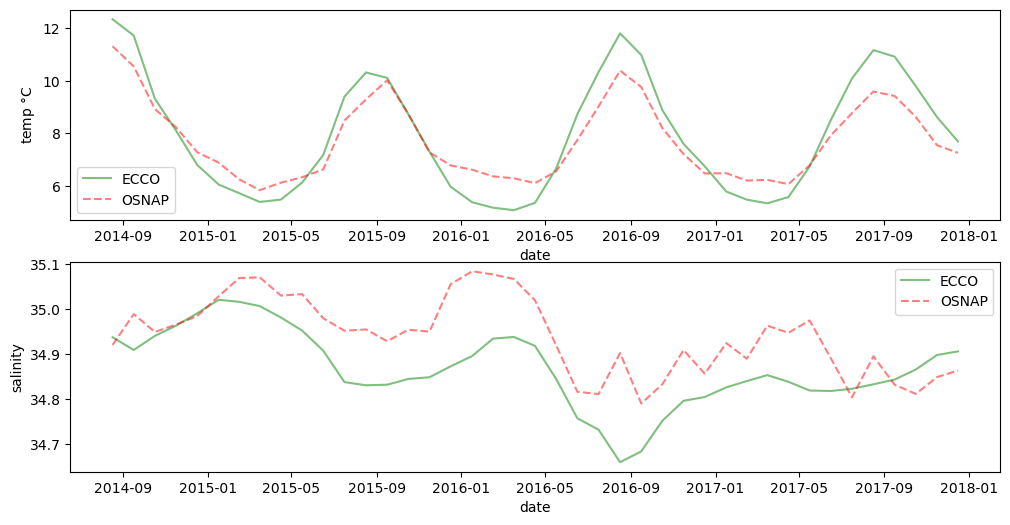

[[1.         0.96991736]
 [0.96991736 1.        ]]
[[1.         0.69749877]
 [0.69749877 1.        ]]


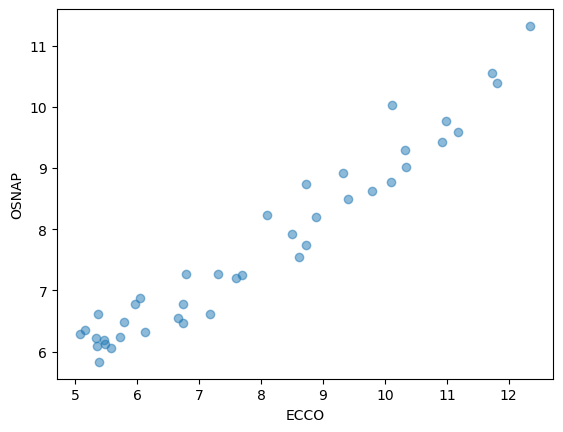

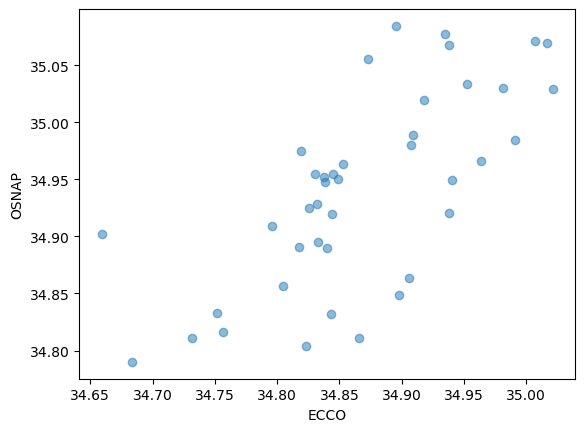

In [9]:
print(df.head())

fig, ax = plt.subplots(2, 1, figsize=(12, 6))
print(df["ecco_theta"])


ax[0].plot(df["ecco_theta"], label="ECCO", color="green", alpha=0.5, linestyle="-")
ax[0].plot(df["osnap_temp"], label="OSNAP", color="red", alpha=0.5, linestyle="--")
ax[0].legend()

ax[0].set_xlabel("date"); ax[0].set_ylabel("temp $\\degree$C")

ax[1].plot(df["ecco_sal"], label="ECCO", color="green", alpha=0.5, linestyle="-")
ax[1].plot(df["osnap_sal"], label="OSNAP", color="red", alpha=0.5, linestyle="--")
ax[1].legend()

ax[1].set_xlabel("date"); ax[1].set_ylabel("salinity")

plt.show()

print(np.corrcoef(df["ecco_theta"], df["osnap_temp"]))
print(np.corrcoef(df["ecco_sal"], df["osnap_sal"]))

plt.plot(df["ecco_theta"], df["osnap_temp"], "o", alpha=0.5)
plt.xlabel("ECCO")
plt.ylabel("OSNAP")
plt.show()

plt.plot(df["ecco_sal"], df["osnap_sal"], "o", alpha=0.5)
plt.xlabel("ECCO")
plt.ylabel("OSNAP")
plt.show()